In [1]:
import os
import imageio
import nglview as nv
import numpy as np
import pytraj as pt 
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns
from hilbertcurve.hilbertcurve import HilbertCurve
from scipy.ndimage import gaussian_filter


In [2]:
import os 
pdbfile = "/home/miemie/Dropbox/Documents/BetaPose/C006TSpe4aeM/C006TSpe4aeM_PDB.pdb"
ncfile = "/home/miemie/Dropbox/Documents/BetaPose/C006TSpe4aeM/C006TSpe4aeM_TRJ.nc"
outpdb = "/home/miemie/Dropbox/Documents/BetaPose/test_featurizer.pdb"
outnc  = "/home/miemie/Dropbox/Documents/BetaPose/test_featurizer.nc"
stride = 1
mask = "@CA,:LIG"
def center_traj(pdbfile, ncfile, outpdb, outnc, mask, stride=1, ):
    os.system(f"rm -f {outnc}") 
    cpptrajcmd = f"echo 'parm {pdbfile}\ntrajin {ncfile} 1 last {stride}\nautoimage {mask}\ncenter {mask}\n \
    rms {mask}\ntrajout {outnc}\nrun' | cpptraj 2>&1 > /dev/null"
    os.system(cpptrajcmd) 
    os.system(f"cp {pdbfile} {outpdb}") 
    if os.path.isfile(outnc):
        print(f"Output trajectory file {outnc} is generated")
center_traj(pdbfile, ncfile, outpdb, outnc, mask)

Output trajectory file /home/miemie/Dropbox/Documents/BetaPose/test_featurizer.nc is generated


In [3]:
class DummyPDB:
    def __init__(self):
        self.pdbline = ""
        self.temp = "ATOM      1  Du  TMP     1       0.000   0.000   0.000  1.00  0.00";
    
    def addCoor(self, vecX, vecY, vecZ, elems):
        newtxt = self.convertToPDB(vecX, vecY, vecZ, elems); 
        self.pdbline += newtxt;
        
    def convertToPDB(self, vecX, vecY, vecZ, elems):
        if (len(vecX) != len(vecY)) or (len(vecX) != len(vecZ)):
            print("Lengths of each dimension are not equil")
        vecX = np.round(vecX, decimals=4)
        vecY = np.round(vecY, decimals=4)
        vecZ = np.round(vecZ, decimals=4)
        pdbline = "";
        
        for i in range(len(vecX)):
            tmpcopy=self.temp;
            indlen = len(str(i));
            atmInd = "{:>5}".format(i+1);
            X = "{:>8}".format(vecX[i]);
            Y = "{:>8}".format(vecY[i]);
            Z = "{:>8}".format(vecZ[i]);
            try:
                Elem = elems[i];
            except:
                Elem = "Du";
            Elem = "{:>4}".format(Elem);
            tmpcopy = tmpcopy[:12]+Elem+tmpcopy[16:]; 
            tmpcopy = tmpcopy[:6]+atmInd+tmpcopy[11:]; 
            tmpcopy = tmpcopy[:30]+X+tmpcopy[38:]; 
            tmpcopy = tmpcopy[:38]+Y+tmpcopy[46:]; 
            tmpcopy = tmpcopy[:46]+Z+tmpcopy[54:];
            pdbline += tmpcopy+"\n"
        
        return pdbline
    
    def writeFile(self, outname):
        self.outname = outname;
        with open(outname, 'w') as outfile:
            outfile.write(self.pdbline)
            
    def show(self):
        viewer = nglview.show_file(self.outname)
        return viewer


In [46]:
import time
import pickle
from numpy import rot90  # FOR rotation of the matrix
from scipy.spatial import distance_matrix
from scipy.ndimage import gaussian_filter

# read the file of trajectory output PDB file (It includes the Ligand atoms)
def Norm_mass_array(array, parm = 9, x0=7, slope=0.015):
    line1 = 1/(1+np.e**(-array+x0))
    baseNr = 1/(1+np.e**(-parm+x0))
    line2 = baseNr + (array-parm)*slope
    status1 = array <= parm
    status2 = array > parm
    template = np.zeros(array.shape)
    template[status1] = line1[status1]
    template[status2] = line2[status2]
    return template

class hilbertize:
    def __init__(self, pdbFile ,trajFile , iter3d, atom_groups, stride=1, search_cutoff=16):
        # Generate the 2D/3D hilbert curve
        self.iter3d = iter3d;
        self.iter2d = int(iter3d*3/2);
        self.length3D = int(2 ** self.iter3d);
        self.length2D = int(np.sqrt(self.length3D**3));
        self.distances = np.array(range(2**(self.iter3d * 3)));
        self.curve3D = HilbertCurve(self.iter3d, 3); 
        self.points3D = np.array(self.curve3D.points_from_distances(self.distances)); 
        self.index3D = np.array(self.curve3D.points_from_distances(self.distances)); 
        self.curve2D = HilbertCurve( (self.iter3d * 3)/2, 2);
        self.points2D = np.array(self.curve2D.points_from_distances(self.distances)); 
        self.atom_groups = atom_groups
        print("Length 3D: {}; length 2D: {}; Total grid point number: {}".format(self.length3D, self.length2D, len(self.distances)))
        
        # Load trajectory
        self.pdbfile = pdbFile; 
        self.trajpdb = pt.load(trajFile, top=pdbFile, stride=stride); 
        self.frameNr = self.trajpdb.crdinfo["n_frames"]; 
        self.frameList = np.arange(1, self.frameNr*stride+1, stride); 
        self.pdb_atomic_names  = np.array([i.name for i in self.trajpdb.top.atoms]).astype(str)
        self.pdb_atomic_number = np.array([i.atomic_number for i in self.trajpdb.top.atoms]).astype(int)
        self.search_cutoff = search_cutoff; 
        
        self.coordinates = {}
        self.selections   = {}
        for i in atom_groups.keys():
            self.init_group(i, atom_groups[i])
        if 'Ligand' in atom_groups.keys():
            com0 = pt.center_of_mass(self.trajpdb, atom_groups["Ligand"], frame_indices=[0]).squeeze(); 
            print(f"Using ligand to align 3D curve {np.round(com0,2)}")
            self.alignBy = "Ligand"
        else: 
            com0 = pt.center_of_mass(self.trajpdb, atom_groups[atom_groups.keys()[0]], frame_indices=[0]).squeeze();
            print(f"Using {atom_groups.keys()[0]} to align 3D curve {com0}")
            self.alignBy = atom_groups.keys()[0]
        self.alignCenter(com0)
        self.curveCenter = np.mean(self.points3D, axis = 0).reshape(1,3); 
            
    def updateCutoff(self, index):
        self.trajpdb.top.set_reference(self.trajpdb[index]);
        self.center = np.mean(self.trajpdb.xyz[index][self.pro_sel], axis=0); 
        self.ligcenter = np.mean(self.trajpdb.xyz[index][self.lig_sel], axis=0);
        self.alignCenter(self.ligcenter); 
        
    def init_group(self, groupname, mask):
        atom_sel = self.trajpdb.top.select(mask);
        if len(atom_sel) == 0: 
            print(f"Warning: There is no atom selected in the group {groupname}, skipping......"); 
            return 
        else: 
            print(f"Group Name: {groupname}; Atoms: {len(atom_sel)} ")
            self.selections[groupname]  = self.trajpdb.top.select(mask);
            self.coordinates[groupname] = self.trajpdb.xyz[0][self.selections[groupname]]
        
    def featurize(self, features):
        self.features = features = [i.lower() for i in features]
        for feature in features:
            if feature.lower() == 'element':
                print("Featurizing element")
                st_elm = time.perf_counter(); 
                # Initialize the container of the descriptors
                self.atom_mass  = {}; 
                self.norm_mass  = {}; 
                self.gauss_mass = {}; 
                for sel in self.selections.keys():
                    self.atom_mass[sel] = []; self.norm_mass[sel] = []; self.gauss_mass[sel] = []; 
                    
                # Firstly, Sequentially process each frames 
                for i in range(len(self.trajpdb)):
                    thisxyz = self.trajpdb.xyz[i]; 
                    # Secondly, sequentially process each selection
                    for sel in self.selections.keys():
                        # Thirdly: Extract coordinates within the cutoff, atom index and
                        selidx = self.selections[sel]; 
                        selxyz = thisxyz[selidx]; 
                        # Fourthly: restrain real candidates
                        cand_status = distance_matrix(selxyz, self.curveCenter) <= self.search_cutoff; 
                        cand_status = cand_status.squeeze(); 
                        cand_index  = selidx[cand_status]; 
                        cand_xyz    = selxyz[cand_status]; 
                        cand_distmatrix = distance_matrix(self.points3D, cand_xyz)
                        cand_diststatus = cand_distmatrix < 1.75
                        # cand_distmatrix < 3.75
                        # Step5 : Iterate all 3D points, find nearest points and assign descriptors                        
                        atom_mass = np.zeros((self.length3D, self.length3D, self.length3D));
                        for ind in self.distances:
                            array_3Didx = tuple(self.index3D[ind]); 
                            if np.any(cand_diststatus[ind,:]):
                                rown = cand_distmatrix[ind,:]; 
                                grpidx = np.where(rown == np.min(rown))[0].item();
                                atmidx = cand_index[grpidx]; 
                                the_atomic_number = self.pdb_atomic_number[atmidx]; 
                                atom_mass[array_3Didx] = the_atomic_number
                            else:
                                atom_mass[array_3Didx] = 0; 
                        # Normalize the atom mass and then smoothen the points by gaussian
                        atom_mass_framen = np.array(atom_mass); 
                        norm_mass_framen = Norm_mass_array(atom_mass_framen)
                        gauss_mass_framen = gaussian_filter(norm_mass_framen, sigma=1)
                        self.atom_mass[sel].append(atom_mass_framen)
                        self.norm_mass[sel].append(norm_mass_framen)
                        self.gauss_mass[sel].append(gauss_mass_framen)
                for _ in self.selections.keys():
                    self.atom_mass[_] = np.array(self.atom_mass[_]); 
                    self.norm_mass[_] = np.array(self.norm_mass[_]);
                    self.gauss_mass[_]= np.array(self.gauss_mass[_]);
                loadtime = time.perf_counter() - st_elm;
                print(f"Element featurization took {loadtime:.2f} seconds; Avg: {loadtime/self.frameNr:.2f}")
            elif feature.lower() == 'entropy':
                print("processing entropy")
                pass
            else: 
                print(f"Decriptor {feature} is not a standard descriptor yet. ")
        
    def save(self, filename):
        with open(filename, "wb") as tmpfile:
            data_to_save={
                "distances":self.distances, 
                "index3D":self.index3D,
                "points3D":self.points3D,
                "points2D":self.points2D,
                "atom_groups": self.atom_groups, 
                "length3D": self.length3D,
                "length2D": self.length2D,
                "frameNr": self.frameNr,
                "frameList": self.frameList,
                
                         }
            data_to_save["features"] = self.features
            if "element" in self.features:
                data_to_save["atom_mass"] = self.atom_mass
                data_to_save["norm_mass"] = self.norm_mass
                data_to_save["gauss_mass"] = self.gauss_mass
            if "entropy" in self.features:
                data_to_save["entropy"] = 0
            pickle.dump(data_to_save ,tmpfile, protocol=pickle.HIGHEST_PROTOCOL)
                
    def alignCenter(self, refCenter):
        diff = np.array(refCenter) - np.mean(self.points3D, axis=0); 
        self.points3D = self.points3D + diff
    def shift(self, shift):
        self.points3D = self.points3D + np.array(shift)
    def scaleToLength(self, refLength):
        LenSc = refLength / self.length3D;
        diff = self.points3D - self.index3D
        self.points3D = diff + self.index3D * LenSc; 
    def scaleByFactor(self, scaleFactor):
        self.points3D = self.points3D * scaleFactor; 

    def gen2D(self, dataset):
        # generate the 2D hilbert curve from the 3D curve
        frames = []
        for frame in dataset: 
            if dataset.dtype.type == np.str_:
                data2d = np.zeros((self.length2D, self.length2D)).astype(str); 
            else: 
                data2d = np.zeros((self.length2D, self.length2D)); 
            for i in range(len(self.points3D)):
                curve3d_idx = tuple(_ for _ in self.index3D[i]); 
                curve2d_idx = tuple(_ for _ in self.points2D[i]);
                data2d[curve2d_idx] = frame[curve3d_idx]
            frames.append(data2d)
        return np.array(frames)
    
    def transpose(self, direction):
        # up, down, left, right
        # two up, two down, two left, two right
        pass

    

PDBFILE = "/home/miemie/Dropbox/Documents/BetaPose/test_featurizer.pdb";
TRAJFILES = [
    "/home/miemie/Dropbox/Documents/BetaPose/test_featurizer.nc", 
            ]; 
GRID_LENGTH = 13;
SEARCH_CUTOFF = 26; 
HILBERT_3D_ITER = 4; 
STRIDE = 50; 

# dictionary that contains the group name and its mask (cpptraj selection)
ATOM_GROUPS = {"Protein":":1-221", "Ligand":":LIG", "Solvent":":T3P,CL-,K+"}
DESCRIPTORS = ["Element", "Entropy"]


# Main function, construct the hilbert fingerprint tensor of a trajectory topology file 
# 1. Construct a hilbert object with designated PDB topology file and iteration/dimension
HBC_pro = hilbertize(PDBFILE, TRAJFILES, HILBERT_3D_ITER, ATOM_GROUPS, stride=STRIDE, search_cutoff=SEARCH_CUTOFF);
# HBC_pro.scaleToLength(GRID_LENGTH)
HBC_pro.featurize(DESCRIPTORS)

HBC_pro.save("./test.pickle")

# 6th 3D hilbert curve wil 

# print(HBC_pro.atom_mass["Protein"][0])
# print(HBC_pro.gauss_mass)number


# # 2. Transform the 3D hilbert curve
# HBC_pro.scaleTo(CUTOFF)

# # 3. Assign element 
# HBC_pro.assignDescriptors(CUTOFF, "pro")

# print("reached the end of this block")

Length 3D: 16; length 2D: 64; Total grid point number: 4096
Group Name: Protein; Atoms: 3573 
Group Name: Ligand; Atoms: 46 
Group Name: Solvent; Atoms: 37533 
Using ligand to align 3D curve [43.76 43.06 34.05]
Featurizing element
Element featurization took 4.36 seconds; Avg: 0.87
processing entropy


In [29]:
x = np.arange(1000).reshape((10,10,10))
ind = 0
ind2 = 2
print(x[ind][ind2])
print(Norm_mass_array(x)[ind][ind2])

[20 21 22 23 24 25 26 27 28 29]
[1.04579708 1.06079708 1.07579708 1.09079708 1.10579708 1.12079708
 1.13579708 1.15079708 1.16579708 1.18079708]


# Pickle file reading and visualization. 

In [47]:
%matplotlib

class feature_reader:
    def __init__(self, pickleFile):
        # Generate the 2D/3D hilbert curve
        with open(pickleFile, "rb") as file1:
            featuredic = pickle.load(file1)
            print(featuredic.keys()); 
            self.distances = featuredic["distances"]; 
            self.points3D  = featuredic["points3D"]; 
            self.index3D   = featuredic["index3D"];
            self.points2D  = featuredic["points2D"];
            self.features  = featuredic["features"];
            self.atom_groups = featuredic["atom_groups"]; 
            self.length3D  = featuredic["length3D"];
            self.length2D  = featuredic["length2D"];
            self.frameList = featuredic["frameList"]
            self.frameNr   = featuredic["frameNr"]
            if "element" in self.features:
                self.atom_mass  = featuredic["atom_mass"]
                self.norm_mass  = featuredic["norm_mass"]
                self.gauss_mass = featuredic["gauss_mass"]
            if "entropy" in self.features:
                self.entropy = featuredic["entropy"]
    def to2Dmatrix(self, dataset):
        newmatrix = np.zeros((self.length2D,self.length2D))
        for i in self.distances: 
            index3d = self.index3D[i]
            index2d = self.points2D[i]
            newmatrix[tuple(index2d)] = dataset[tuple(index3d)]; 
        return newmatrix
    
    def selectData(self, maintype, select_group, subtype="gauss"):
        if maintype == "element":
            if subtype == "atom":
                data = self.atom_mass[select_group]; 
            elif subtype == "norm":
                data = self.norm_mass[select_group]; 
            elif subtype == "gauss": 
                data = self.gauss_mass[select_group]; 
            else: 
                print(f"Not Found the subtype {subtype}"); 
                data = self.gauss_mass[select_group]
        elif maintype == "element":
            pass 
        return data

    def imshow2D(self, maintype, select_group, indice, subtype="gauss", cmap="inferno", vmax=1, vmin=0):
        data = self.selectData(maintype, select_group, subtype=subtype)[indice]
        if np.max(data) < vmax:
            vmax = np.max(data); 
        if np.min(data) > vmin: 
            vmin = np.min(data)
        plt.clf()
        data2D = self.to2Dmatrix(data)
        plt.imshow(data2D, cmap=cmap)
        cbar = plt.colorbar()
        plt.clim(0, 1)

    def interactive2D(self, maintype, select_group, outputdir="/tmp/",outputprefix="tmpfig_", cmap="inferno", vmax=None, vmin=0, subtype="gauss"):
        data = self.selectData(maintype, select_group, subtype=subtype)
        if vmax == None or np.max(data) < vmax:
            vmax = np.max(data); 
        if vmin == None and np.min(data) > vmin: 
            vmin = np.min(data)
        cbar = False; 
        plt.ion();
        plt.clf();
        figlist=[];
        for i in range(self.frameNr):
            # if the distances are identical, use inshow rather than pcolormesh. 
            data_2d = self.to2Dmatrix(data[i])
            plt.imshow(data_2d, cmap=cmap)
            if not cbar:
                cbar = plt.colorbar()
            plt.clim(vmin, vmax)
            plt.xlabel(f"Frame {self.frameList[i]}")
            plt.pause(0.5)
            figname = f"{outputdir}/{outputprefix}{i}.png"
            plt.savefig(figname, format="png")
            figlist.append(figname)
        plt.ioff(); 
        plt.show(); 
        with imageio.get_writer(f"{outputdir}/{outputprefix}_{select_group}_{maintype}_{subtype}.gif", mode="I") as gif1:
            for i in figlist:
                image = imageio.imread(i); 
                gif1.append_data(image); 
        return figlist
    
    def scatter3D(self, maintype, select_group, indice, subtype="gauss"):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        plt.ion()
        
        cmap_protein = cm.get_cmap("Blues")
        for i in distances: 
            theposition = points3D[i].tolist(); 
            theindex = index3D[i]; 
            mass_val = protein_normmass[tuple(theindex)]
            thecolor = cmap_protein(mass_val)
            if mass_val > 0.1:
                print(f"{mass_val}, color is {thecolor}")
                ax.scatter(*theposition, color=thecolor)
        
        
                
    def show3D(self, descriptor, addprotein=False, ):
        cube = self.cube = DummyPDB();
        pdbstr = cube.convertToPDB(self.points3D[:,0],self.points3D[:,1],
                                   self.points3D[:,2],descriptor)
        
        with open("/tmp/tmpbpose.pdb","w") as outfile:
            outfile.write(pdbstr)
        viewer = nv.show_file("/tmp/tmpbpose.pdb")
        viewer[0].clear_representations()
        if addprotein:
            nearAtomSel = "@"+",".join([str(i) for i in self.trajpdb.top.select(":LIG<:5 & !:LIG, T3P, HOH, WAT, SPC &!@H*")])
            viewer.add_component(self.pdbfile)
            viewer[1].clear_representations()
            viewer[1].add_licorice(selection = nearAtomSel, opacity=0.7)
            viewer[1].add_cartoon(selection = "protein")
            viewer[1].add_hyperball(selection = "LIG")
            
        # Add basic viewer representations
        viewer[0].add_line(selection="all", opacity=0.7)
        viewer[0].add_surface(selection="all", opacity=0.3, surfaceType="sas", 
                              probeRadius=0.001, contour=True, smooth=5)
        viewer.background = "gray"
        return viewer
    
    def show2D(self, descriptor, savepdb="/tmp/tmpbpose.pdb"):
        plane = self.plane = DummyPDB();
        print(len(self.points2D[:,0]))
        pdbstr = plane.convertToPDB(self.points2D[:,0], self.points2D[:,1], 
                                    np.ones(4096), descriptor)
        with open(savepdb, "w") as outfile:
            outfile.write(pdbstr)
        viewer = nv.show_file(savepdb)
        viewer.clear_representations()
        viewer[0].add_ball_and_stick(selection="all")
        viewer.background = "gray"
        return viewer
        
        
feature1 = feature_reader("./test.pickle")
print(feature1.atom_groups)

# feature1.imshow2D("element", "Protein", 0, subtype="guass")
# feature1.scatter3D("element", "Ligand", 0, subtype="guass")
feature1.interactive2D("element", "Ligand", subtype="atom", cmap="inferno")
feature1.interactive2D("element", "Ligand", subtype="norm", cmap="inferno")
feature1.interactive2D("element", "Ligand", subtype="gauss", cmap="inferno")

feature1.interactive2D("element", "Protein", subtype="atom", cmap="inferno")
feature1.interactive2D("element", "Protein", subtype="norm", cmap="inferno")
feature1.interactive2D("element", "Protein", subtype="gauss", cmap="inferno")

feature1.interactive2D("element", "Solvent", subtype="atom", cmap="inferno")
feature1.interactive2D("element", "Solvent", subtype="norm", cmap="inferno")
feature1.interactive2D("element", "Solvent", subtype="gauss", cmap="inferno")


# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# plt.ion()

# cmap_protein = cm.get_cmap("Blues")
# for i in distances: 
#     theposition = points3D[i].tolist(); 
#     theindex = index3D[i]; 
#     mass_val = protein_normmass[tuple(theindex)]
#     thecolor = cmap_protein(mass_val)
#     if mass_val > 0.1:
#         print(f"{mass_val}, color is {thecolor}")
#         ax.scatter(*theposition, color=thecolor)

# cmap_ligand  = cm.get_cmap("Greens")
# for i in distances: 
#     theposition = points3D[i].tolist(); 
#     theindex = index3D[i]; 
#     mass_val = ligand_normmass[tuple(theindex)]
#     thecolor = cmap_ligand(mass_val)
#     if mass_val > 0.1:
#         print(f"{mass_val}, color is {thecolor}")
#         ax.scatter(*theposition, color=thecolor)

# cmap_water   = cm.get_cmap("OrRd")
# for i in distances: 
#     theposition = points3D[i].tolist(); 
#     theindex = index3D[i]; 
#     mass_val = water_normmass[tuple(theindex)]
#     thecolor = cmap_water(mass_val)
#     if mass_val > 0.1:
#         print(f"{mass_val}, color is {thecolor}")
#         ax.scatter(*theposition, color=thecolor)

Using matplotlib backend: Qt5Agg
dict_keys(['distances', 'index3D', 'points3D', 'points2D', 'atom_groups', 'length3D', 'length2D', 'frameNr', 'frameList', 'features', 'atom_mass', 'norm_mass', 'gauss_mass', 'entropy'])
{'Protein': ':1-221', 'Ligand': ':LIG', 'Solvent': ':T3P,CL-,K+'}


['/tmp//tmpfig_0.png',
 '/tmp//tmpfig_1.png',
 '/tmp//tmpfig_2.png',
 '/tmp//tmpfig_3.png',
 '/tmp//tmpfig_4.png']

array([[30.43170459, 30.02964606, 29.77664426],
       [30.43170459, 30.02964606, 30.77664426],
       [30.43170459, 31.02964606, 30.77664426],
       ...,
       [45.43170459, 31.02964606, 30.77664426],
       [45.43170459, 30.02964606, 30.77664426],
       [45.43170459, 30.02964606, 29.77664426]])

In [16]:
HBC_pro.interactive2D(HBC_pro.res2D[1])


Using matplotlib backend: Qt5Agg


In [13]:
print(len(HBC_pro.res2D))
HBC_pro.interactive2D(HBC_pro.res2D[2])
# print(HBC_pro.ATNDIST2D)


# HBC_pro.show2D(1, 0)
# HBC_pro.plot2D(1, 1)
# print([i for i in HBC_pro.res2D[1].max(axis=(-1,-2))])
# print(HBC_pro.res2D[1].min())

# print(HBC_pro.ELMDIST2D)


AttributeError: 'hilbertize' object has no attribute 'res2D'

In [115]:
xyz = HBC_pro.trajpdb.xyz[0]
a = distance_matrix(xyz, np.array([20, 20, 20]).reshape(1,3)) < 7

a = a.squeeze()

np.arange(len(xyz))[a]


a = HBC_pro.atom_mass
    
def Norm_mass(array, parm = 9, x0=7, slope=0.015):
    return np.array([1/(1+np.e**(-t+x0)) if t <= parm else S(parm) + (t-parm)*slope for t in array])

def Norm_mass_array(array, parm = 9, x0=7, slope=0.015):
    line1 = 1/(1+np.e**(-array+x0))
    baseNr = 1/(1+np.e**(-parm+x0))
    line2 = baseNr + (array-parm)*slope
    status1 = array <= parm
    status2 = array > parm
    template = np.zeros(array.shape)
    template[status1] = line1[status1]
    template[status2] = line2[status2]
    return template
    
#     return np.array([1/(1+np.e**(-t+x0)) if t <= parm else S(parm) + (t-parm)*slope for t in array])
print(HBC_pro.atom_mass["Protein"])
Norm_mass_array(HBC_pro.atom_mass["Protein"])

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 1. 1. ... 0. 0. 0.]
   [1. 1. 1. ... 0. 0. 0.]
   [1. 1. 8. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [8. 8. 1. ... 0. 0. 0.]
   [8. 8. 1. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [1. 1. 8. ... 0. 0. 0.]
   [1. 1. 8. ... 0. 0. 0.]
   [8. 1. 8. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [8. 1. 1. ... 0. 1. 1.]
   [8. 1. 1. ... 1. 1. 1.]
   [1. 1. 8. ... 8. 1. 1.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [1. 1. 0. ... 0. 0. 0.]
   [8. 1. 1. ... 8. 1. 1.]
   [1. 1. 8. ... 8. 1. 1.]]

  [[1. 0. 0. ... 0. 0. 0.]
   [1. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [1. 1. 0. ... 0. 0. 0.]
   [1. 0. 0. ... 0. 0. 

array([[[[0.00091105, 0.00091105, 0.00091105, ..., 0.00091105,
          0.00091105, 0.00091105],
         [0.00091105, 0.00091105, 0.00091105, ..., 0.00091105,
          0.00091105, 0.00091105],
         [0.00091105, 0.00091105, 0.00091105, ..., 0.00091105,
          0.00091105, 0.00091105],
         ...,
         [0.00091105, 0.00247262, 0.00247262, ..., 0.00091105,
          0.00091105, 0.00091105],
         [0.00247262, 0.00247262, 0.00247262, ..., 0.00091105,
          0.00091105, 0.00091105],
         [0.00247262, 0.00247262, 0.73105858, ..., 0.00091105,
          0.00091105, 0.00091105]],

        [[0.00091105, 0.00091105, 0.00091105, ..., 0.00091105,
          0.00091105, 0.00091105],
         [0.00091105, 0.00091105, 0.00091105, ..., 0.00091105,
          0.00091105, 0.00091105],
         [0.00091105, 0.00091105, 0.00091105, ..., 0.00091105,
          0.00091105, 0.00091105],
         ...,
         [0.00091105, 0.00091105, 0.00091105, ..., 0.00091105,
          0.00091105, 0.0

# Obsolete functions
# Used to use this function to generate the xyz of the trajectory. 

In [39]:
####################################################################################################
################################## Obsolete coordinate processor ###################################
####################################################################################################
    def processXYZ(self, filename):
        with open(filename,"r") as file1:
            self.pdbfile = [i.strip('\n') for i in  file1.readlines()] 
            
        self.pdbx = []; 
        self.pdby = []; 
        self.pdbz = []; 
        self.ligx=[]; 
        self.ligy=[]; 
        self.ligz=[];
        for i in self.pdbfile:
            if (("ATOM" in i) or ("HETATM" in i)) and (i[17:20] not in self.ligNamelst):
                self.pdbx.append(float(i[30:38].strip())); 
                self.pdby.append(float(i[38:46].strip())); 
                self.pdbz.append(float(i[46:54].strip())); 
            elif ("HETATM" in i) and (i[17:20] in self.ligNamelst):
                self.ligx.append(float(i[30:38].strip())); 
                self.ligy.append(float(i[38:46].strip())); 
                self.ligz.append(float(i[46:54].strip())); 
        self.pdbx = np.array(self.pdbx); 
        self.pdby = np.array(self.pdby); 
        self.pdbz = np.array(self.pdbz); 
        self.ligx = np.array(self.ligx); 
        self.ligy = np.array(self.ligy); 
        self.ligz = np.array(self.ligz);
        self.center = np.array([np.mean(self.pdbx), np.mean(self.pdby), np.mean(self.pdbz)])
        self.ligcenter = np.array([np.mean(self.ligx), np.mean(self.ligy), np.mean(self.ligz)])

        try:
            self.center = np.array([i for i in pt.center_of_geometry(self.trajpdb)[0]])
        except:
            self.center = np.array([np.mean(self.pdbx), np.mean(self.pdby), np.mean(self.pdbz)])
                
        try: 
            AtomLst = [i.name for i in self.trajpdb.top.atoms]
            c=0;
            for i in self.pdbfile:
                if ("ATOM" in i) or ("HETATM" in i):
                    self.elems.append(AtomLst[c])
                    c += 1
        except:
            self.elems = []; 
            for i in self.pdbfile:
                if ("ATOM" in i) or ("HETATM" in i):
                    self.elems.append(i[12:16].strip())
        self.elems = np.array(self.elems)
        
    def from_mol2(self, filename):
        with open(filename,"r") as file2:
            self.mol2file = [i.strip('\n') for i in file2.readlines()]
        inatom = False
        self.mol2x=[];self.mol2y=[];self.mol2z=[];
        for i in self.mol2file:
            if ("<TRIPOS>ATOM" in i):
                inatom = True;
                continue
            elif ("<TRIPOS>BOND" in i):
                inatom = False
            if (inatom):
                self.mol2x.append(float(i.split()[2]))
                self.mol2y.append(float(i.split()[3]))
                self.mol2z.append(float(i.split()[4]))
        self.center = np.array([np.mean(self.mol2x), np.mean(self.mol2y),np.mean(self.mol2z)])
        self.ismol2 = True;
    
    # That is the function of set curoff ????
    def setCutoff(self, cutoff):
        print("Chainging the cutoff value and updating the selected atoms")
        self.cutoff = cutoff;
        cutoff = str(cutoff); 
        self.atomlist = self.trajpdb.top.select(":LIG<:"+cutoff+" &! :LIG, MDL, TRA"); 
        self.atomlist_nowat = self.trajpdb.top.select(":LIG<:"+cutoff+" &! :LIG, MDL, TRA,T3P, HOH,WAT,T4P"); 
        print("Updating cutoff: atom number within cutoff: ", len(self.atomlist))
        print("Updating cutoff: atom number within cutoff not water: ",len(self.atomlist_nowat))
        self.mask = "@"+",".join([str(i) for i in self.atomlist])
        self.mask_nowat = "@"+",".join([str(i) for i in self.atomlist_nowat])
        
####################################################################################################
####################################### Obsolete featurizer ########################################
####################################################################################################
    def assignDescriptors(self, cutoff, atomtype, framelist=[0,-1,1], rVDW=1.75, rSAS=3.75):
        # Read the information about [Element, atomic coordinate, residue ID]
        sqVDW = rVDW ** 2; 
        sqSAS = rSAS ** 2; 
        sqdist = lambda p, xyz: np.sum((p - xyz)**2, axis = 1)
        
        if (atomtype == "pro"):
            selection = self.pro_sel; 
        elif (atomtype == "lig"):
            selection = self.lig_sel; 
        elif (atomtype == "wat"):
            selection = self.wat_sel; 
        elif (atomtype == "ion"):
            selection = self.ion_sel; 
        elif (atomtype == "all"):
            selection = self.trajpdb.top.select(":*");
        elif (atomtype == "prolig"):
            selection = self.prolig_sel;
        elif (atomtype == "proligion"):
            selection = self.proligion_sel;
        elif (atomtype == "nolig"):
            selection = self.nolig_sel; 
        elif (atomtype == "nowat"):
            selection = self.nowat_sel;
        
        # Step 0: Get descriptors
        elemlst = np.array([i.name for i in self.trajpdb.top.atoms])[selection]
        atomNrlst = np.array([i.atomic_number for i in self.trajpdb.top.atoms])[selection]
        resIDlst = np.array([i.resid for i in self.trajpdb.top.atoms])[selection]
        
        c_frame = 0; 
        self.framelst = []; 
        element_frames = []; 
        atomnr_frames  = []; 
        resid_frames   = []; 
        for i in range(len(self.trajpdb)):
            # Step1: update reference coordinates
            self.updateCutoff(i); 
            mask = "@"+",".join([str(_) for _ in self.lig_sel])+"<@{}".format(self.search_cutoff); 
            self.framelst.append(i); 
            theframe = self.trajpdb.xyz[i]; 
            cand_ids = self.trajpdb.top.select(mask); 
            candidates = theframe[cand_ids];
            
            elems  = np.zeros((self.length3D, self.length3D, self.length3D)).astype(str); 
            atoms  = np.zeros((self.length3D, self.length3D, self.length3D)); 
            resids = np.zeros((self.length3D, self.length3D, self.length3D));

            c1=0; 
            c2=0; 
            c3=0; 
            
            # Step2: find nearest points and assign descriptors
            # Iterate through all points in the 3D hilbert curve
            for j in range(len(self.points3D)):
                dists = sqdist(self.points3D[j], candidates);
                distmin = np.min(dists);
                idx = np.squeeze(np.where(dists == distmin));
                curve3d_idx = self.index3D[j]
                
                if (distmin < sqVDW):
                    c1 += 1
                    elems[curve3d_idx]  = elemlst[idx]; 
                    atoms[curve3d_idx]  = atomNrlst[idx]; 
                    resids[curve3d_idx] = resIDlst[idx]; 
                elif (distmin > sqVDW and distmin < sqSAS):
                    c2 += 1
                    elems[curve3d_idx]  = "H"
                else:
                    c3 += 1
                    elems[curve3d_idx]  = "Du"
            
            # finished the collection of one frame. 
            element_frames.append(elems); 
            atomnr_frames.append(atoms); 
            resid_frames.append(resids); 
            
            # Step3: Process the next frame
            c_frame += 1; 
            if (c_frame % 20 == 0):
                print("Assigned 3D hilbert cells: {:d} frames; Found {:d} | {:d} | {:d}".format(c_frame, c1, c2, c3))
        
        self.element_f3d = np.array(element_frames); 
        self.atomnr_f3d  = np.array(atomnr_frames)
        self.resid_f3d   = np.array(resid_frames); 
        
        print(self.element_f3d.shape)
        print(self.atomnr_f3d.shape)
        print(self.resid_f3d.shape)
        
        self.smoothen("points", weights="weights"); 
        
        
####################################################################################################
############################## Put a trajectory to the center of box ###############################
####################################################################################################
def centerTraj(topFile, coorFile, mask=":LIG<:5&!:LIG", prefix="testout"):
    traj = pt.load(coorFile, top=topFile)
    traj.top.set_reference(traj[0])
    traj = pt.autoimage(traj, mask=mask)
    pt.write_traj(prefix+".nc", traj, overwrite=True)
    pt.write_traj(prefix+".pdb", traj, frame_indices=[0], overwrite=True)
    return traj
    
# 1. Uniform the name of the ligand
# 2. Change PDB header of protein part from HETATM to ATOM
# 3. Change the atom name of 4-letter atom name
def cleanPDB(filename, outfilename, watcode="T3P"):
    file1=open(filename, 'r'); 
    file2=open(outfilename, 'w');
    HETATMdic = {
        'CL':'CL-','NA':'NA+', 'K':'K+ ','CL-':'CL-','NA+':'NA+', 'K+':'K+ ', 
        'MDL':'LIG','LIG':'LIG',
        'SOL':watcode, 'T3P':watcode, 'SPC':watcode, 'HOH':watcode, 'WAT':watcode,'T4P':watcode, 'T3E':watcode
    }

    for i in file1:
        if "TER"  in i:
            continue
        if i[17:20].strip().upper() in HETATMdic.keys():
            i='HETATM'+i[6:17]+HETATMdic[i[17:20].strip().upper()]+i[20:];
        # Two special occasions ;
        # 1. Atom name by 4 letters e.g. 1HD2 -> HD21; Ligand should be excluded; This error only occurres in hydrogen atom
        #     In case CAMPARI naming does not associate with the Charmm forcefield naming
        # 2. Correct the terminal hydrogen atoms (not include Ligand)
        if (len(i[12:16].strip()) == 4) and (i[17:20]!='MDL') and (re.match(r' [0-9]H.[0-9] ', i[12:16])):
            i=i[:12]+i[13:16]+i[12]+i[16:];
        elif (i[0:4]=='ATOM') and ((i[12:16].strip()=='H1') or (i[12:16].strip()=='H2') or (i[12:16].strip()=='H3')):
            i=i[:12]+' '+'HT'+i[14]+i[16:];
        if ('FOR' in i) and (i[13:16].strip() == 'HN'):
            i=i[:13]+'H  '+i[16:];
        file2.write(i);
    file1.close();
    file2.close();

# Put the trajectory to the center of the box 
thetraj = centerTraj("./C006TSpe4aeM/C006TSpe4aeM_PDB.pdb", "./C006TSpe4aeM/C006TSpe4aeM_TRJ.nc", prefix="testout"); 
# clean the PDB file
cleanPDB("testout.pdb", "test_clean.pdb", watcode="T3P"); 
print("Finished the PDB/Coordinate preparation")


a=[0,-1,3]
print(thetraj[a])
print(np.arange(100)[a])





SyntaxError: invalid syntax (1020261499.py, line 3)

# Try FFT function

100
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[False False False ... False False False]
[[3.+0.j 0.+0.j 0.+0.j]
 [3.+0.j 0.+0.j 0.+0.j]]


/home/miemie/miniconda3/envs/hilbert/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


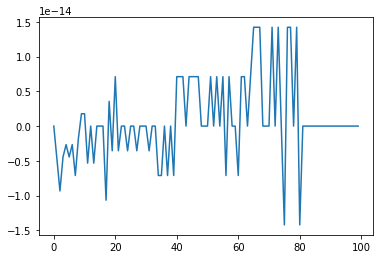

In [11]:
np.fft.fft([1,2,3,4,5])

b=[i for i in range(100)]

a=np.fft.fft(range(100))

print(len(a))

c=np.fft.ifft(a)

print(b)
print(b==c)
# print(round(c[0]))
d = np.ones((2,3))
e = np.fft.fft(d)

print(e)

plt.clf()
plt.plot(b,b-c)
plt.show()

# Read the XML forcefield file

In [186]:
from xml.dom import minidom
import xml.etree.ElementTree as ET

amberxml = "/home/miemie/Win/MLproject/BetaPose/Forcefield/ff14SB.xml"
charmmxml = "/home/miemie/Win/MLproject/BetaPose/Forcefield/charmm36_nowaters.xml"

ff14SB = minidom.parse(amberxml)
charmm36 = minidom.parse(charmmxml)

root = ET.Element("Forcefield")
print(dir(ff14SB))

reslist = ['ALA','ARG','ASN','ASP','CYS','GLU','GLN','GLY','ILE','LEU',
           'LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL']
hislist = {'HID':"HSD",'HIE':"HSE",'HIP':"HSP"}

print("There are ", len(reslist)," residues")

atomlist = ['C','CA','CB','CD','CD1','CD2','CE','CE1','CE2','CE3','CG','CG1',
            'CG2','CH2','CZ','CZ2','CZ3','HA','HA1','HA2','HB','HB1','HB2',
            'HB3','HD1','HD11','HD12','HD13','HD2','HD21','HD22','HD23','HD3',
            'HE','HE1','HE2','HE21','HE22','HE3','HG','HG1','HG11','HG12',
            'HG13','HG2','HG21','HG22','HG23','HH','HH11','HH12','HH2','HH21',
            'HH22','HN','HT1','HT2','HT3','HZ','HZ1','HZ2','HZ3','N','ND1',
            'ND2','NE','NE1','NE2','NH1','NH2','NZ','O','OD1','OD2','OE1',
            'OE2','OG','OG1','OH','SD', "H","SG","HG"]
atomNameMap = {'H': 'HN', 'HG3':'HG1', 'HB3':'HB1', 'HD3':'HD1', "HG": "HG1", "HA3":"HA1", 'HE3':'HE1', 
               'HG13': 'HG11', 'CD1':'CD', 'HD12': 'HD2', 'HD11':'HD1', 'HD13': 'HD3'}

residues  = charmm36.getElementsByTagName("Residue");
residues2 = ff14SB.getElementsByTagName("Residue");

for resname in reslist:
    tmpresidue = ET.SubElement(root, "Residue")
    tmpresidue.set("name", resname)
    tmpres  = [res for res in ff14SB.getElementsByTagName("Residue") if res.attributes["name"].value == resname]; 
    tmpres2 = [res for res in charmm36.getElementsByTagName("Residue") if res.attributes["name"].value == resname];
    
    if (len(tmpres) > 0):
        tmpres = tmpres[0]
    if (len(tmpres2) > 0):
        tmpres2 = tmpres2[0]
        
    a = set([ j.attributes["name"].value for j in tmpres.getElementsByTagName("Atom") ])
    b = set([ j.attributes["name"].value for j in tmpres2.getElementsByTagName("Atom") ])
    intersections = a.intersection(b)
    for j in intersections:
        tmpatom1 = [i for i in tmpres.getElementsByTagName("Atom") if i.attributes["name"].value == j][0]
        tmpatom2 = [i for i in tmpres2.getElementsByTagName("Atom") if i.attributes["name"].value == j][0]
        addatom = ET.SubElement(tmpresidue, "Atom")
        addatom.set('name',    tmpatom1.attributes["name"].value)
        addatom.set('type',    tmpatom1.attributes["type"].value)
        addatom.set('charge',  tmpatom1.attributes["charge"].value)
        addatom.set('charge2', tmpatom2.attributes["charge"].value)
    diffa = a.difference(b)
    diffb = b.difference(a)
    print(diffa,diffb)
    for j in diffa:
        charmmatom = atomNameMap[j]
        tmpatom1 = [i for i in tmpres.getElementsByTagName("Atom") if i.attributes["name"].value == j][0]
        tmpatom2 = [i for i in tmpres2.getElementsByTagName("Atom") if i.attributes["name"].value == charmmatom][0]

        addatom = ET.SubElement(tmpresidue, "Atom")
        addatom.set('name',    tmpatom1.attributes["name"].value)
        addatom.set('type1',   tmpatom1.attributes["type"].value)
        addatom.set('type2',   tmpatom2.attributes["type"].value)
        addatom.set('charge',  tmpatom1.attributes["charge"].value)
        addatom.set('charge2', tmpatom2.attributes["charge"].value)

for resname in hislist.keys():
    amberNM = resname
    charmNM = hislist[amberNM]
    print(amberNM, charmNM)
    charmres = [res for res in charmm36.getElementsByTagName("Residue") if res.attributes["name"].value == charmNM][0];
    amberres = [res for res in ff14SB.getElementsByTagName("Residue") if res.attributes["name"].value == amberNM][0]; 
    
    tmpcharmres = ET.SubElement(root, "Residue")
    tmpcharmres.set("name", charmNM)
    print(len([i for i in charmres.getElementsByTagName("Atom")]))
    for i in [i for i in charmres.getElementsByTagName("Atom")]:
        addatomC = ET.SubElement(tmpcharmres, "Atom")
        addatomC.set('name',   i.attributes["name"].value)
        addatomC.set('type',   i.attributes["type"].value)
        addatomC.set('charge', i.attributes["charge"].value)
    
    tmpamber = ET.SubElement(root, "Residue")
    tmpamber.set("name", amberNM)
    print(len([i for i in amberres.getElementsByTagName("Atom")]))
    for i in [i for i in amberres.getElementsByTagName("Atom")]:
        addatomA = ET.SubElement(tmpamber, "Atom")
        addatomA.set('name',   i.attributes["name"].value)
        addatomA.set('type',   i.attributes["type"].value)
        addatomA.set('charge', i.attributes["charge"].value)


tmpstring = minidom.parseString(ET.tostring(root, encoding="unicode")).toprettyxml()
# print(tmpstring)
with open("/tmp/testcompile.xml", "w") as file1:
    file1.write(tmpstring)


['ATTRIBUTE_NODE', 'CDATA_SECTION_NODE', 'COMMENT_NODE', 'DOCUMENT_FRAGMENT_NODE', 'DOCUMENT_NODE', 'DOCUMENT_TYPE_NODE', 'ELEMENT_NODE', 'ENTITY_NODE', 'ENTITY_REFERENCE_NODE', 'NOTATION_NODE', 'PROCESSING_INSTRUCTION_NODE', 'TEXT_NODE', '__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_call_user_data_handler', '_child_node_types', '_create_entity', '_create_notation', '_elem_info', '_get_actualEncoding', '_get_async', '_get_childNodes', '_get_doctype', '_get_documentElement', '_get_documentURI', '_get_elem_info', '_get_encoding', '_get_errorHandler', '_get_firstChild', '_get_lastChild', '_get_localName', '_get_standalone', '_get_strictErrorChec

In [43]:
import xml.etree.ElementTree as ET
watff = "/home/miemie/Win/MLproject/BetaPose/Forcefield/test_wat.xml"

a = ET.parse(watff)
print(dir(a))
FF = ET.Element('ForceField')
residue1 = ET.SubElement(FF, "Residue")

residue1.set('name','T3P')
residue1.text = "T3P"
print(dir(residue1))

mydata = ET.tostring(FF)
print(mydata)
with open("/tmp/residue.xml", "bw") as file1:
    file1.write(mydata)




watxml=minidom.parse(watff)
residues = watxml.getElementsByTagName("Residue")
for i in residues:
    print(i.attributes["name"].value, i.attributes["source"].value)


# print(dir(watxml))
# watxml.saveXML(open("/tmp/test.xml","w"))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_root', '_setroot', 'find', 'findall', 'findtext', 'getiterator', 'getroot', 'iter', 'iterfind', 'parse', 'write', 'write_c14n']
['__class__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'attrib', 'clear', 'extend', 'find', 'findall', 'findtext', 'get', 'getchildren', 'getiterator'

In [48]:
data = ET.Element('data')
items = ET.SubElement(data, 'items')
item1 = ET.SubElement(items, 'item')
item2 = ET.SubElement(items, 'item')
item1.set('name','item1')
item2.set('name','item2')
item1.text = 'item1abc'
item2.text = 'item2abc'

# create a new XML file with the results
mydata = ET.tostring(data , encoding="unicode")
print(mydata)
myfile = open("/tmp/items2.xml", "w")
myfile.write(mydata)

<data><items><item name="item1">item1abc</item><item name="item2">item2abc</item></items></data>


96

In [12]:
from datetime import datetime
import time
time.perf_counter()
reslist = ['ALA','ARG','ASN','ASP','CYS','GLU','GLN','GLY','ILE','LEU',
           'LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL',
           'HIS','HID','HIE','HIP', "HSD", "HSE", "HSP"]

atomNameMap = {'H': 'HN', 'HG3':'HG1', 'HB3':'HB1', 'HD3':'HD1', "HG": "HG1", "HA3":"HA1", 'HE3':'HE1', 
               'HG13': 'HG11', 'CD1':'CD', 'HD12': 'HD2', 'HD11':'HD1', 'HD13': 'HD3'}
print(len(reslist))
print(atomNameMap.keys())

26
dict_keys(['H', 'HG3', 'HB3', 'HD3', 'HG', 'HA3', 'HE3', 'HG13', 'CD1', 'HD12', 'HD11', 'HD13'])
